In [3]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

In [18]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('random_extreme_values.csv')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)
    df.to_csv('Bending_extreme_random.csv', index=False)
    return df


df = read_data(type='BENDING', folder='Random_extreme_bending', length=100)
df.head()

,mean_force,max_force,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs
0,24.350710,28.808236,2.60,1.92,1.69,76.82,129.00,243.48,82934.6
1,28.681169,35.407410,3.07,1.63,1.23,75.38,127.75,283.34,74316.0
2,23.515011,28.318236,2.57,1.82,1.17,75.87,126.81,298.99,63776.2
3,24.679426,28.818324,2.46,2.20,1.07,74.80,128.24,310.38,68407.8
4,29.369045,39.340758,2.89,2.06,1.78,76.59,129.11,300.87,78130.4


In [4]:
extremal_df = pd.read_csv('Bending_extreme_random.csv')
training_df = pd.read_csv('Monte_Carlo_10000/training_data.csv')

Fjerner punkter hvor ingen av variablene er ekstreme

In [11]:
for i in range(len(extremal_df)):
    if extremal_df['outer_wall_thickness'][i] <= 2.5 or extremal_df['outer_wall_thickness'][i] >= 2.9:
        break
    if extremal_df['inside_wall_side_thickness'][i] <= 1.7 or extremal_df['inside_wall_side_thickness'][i] >= 2.3:
        break
    if extremal_df['inside_wall_middle_thickness'][i] <= 1.2 or extremal_df['inside_wall_middle_thickness'][i] >= 1.8:
        break
    if extremal_df['height'][i] <= 75.2 or extremal_df['height'][i] >= 76.6:
        break
    if extremal_df['width'][i] <= 127.2 or extremal_df['width'][i] >= 128.6:
        break
    if extremal_df['sigma0'][i] <= 240.39 or extremal_df['sigma0'][i] >= 293.81:
        break
    if extremal_df['youngs'][i] <= 63000 or extremal_df['young_modulus'][i] >= 77000:
        break
    extremal_df = extremal_df.drop(i)
extremal_df.reset_index(drop=True, inplace=True)

print(len(extremal_df))

100


In [20]:
X = training_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = training_df[['mean_force']].values
Y_EXT = extremal_df[['mean_force']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
generating_array = extremal_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
generating_array_scaled = scaler.transform(generating_array)
X_val = scaler.transform(X_val)

[1.00000000e-07 1.00100110e+00 2.00200210e+00 3.00300310e+00
 4.00400410e+00 5.00500510e+00 6.00600611e+00 7.00700711e+00
 8.00800811e+00 9.00900911e+00 1.00100101e+01 1.10110111e+01
 1.20120121e+01 1.30130131e+01 1.40140141e+01 1.50150151e+01
 1.60160161e+01 1.70170171e+01 1.80180181e+01 1.90190191e+01
 2.00200201e+01 2.10210211e+01 2.20220221e+01 2.30230231e+01
 2.40240241e+01 2.50250251e+01 2.60260261e+01 2.70270271e+01
 2.80280281e+01 2.90290291e+01 3.00300301e+01 3.10310311e+01
 3.20320321e+01 3.30330331e+01 3.40340341e+01 3.50350351e+01
 3.60360361e+01 3.70370371e+01 3.80380381e+01 3.90390391e+01
 4.00400401e+01 4.10410411e+01 4.20420421e+01 4.30430431e+01
 4.40440441e+01 4.50450451e+01 4.60460461e+01 4.70470471e+01
 4.80480481e+01 4.90490491e+01 5.00500501e+01 5.10510511e+01
 5.20520521e+01 5.30530531e+01 5.40540541e+01 5.50550551e+01
 5.60560562e+01 5.70570572e+01 5.80580582e+01 5.90590592e+01
 6.00600602e+01 6.10610612e+01 6.20620622e+01 6.30630632e+01
 6.40640642e+01 6.506506

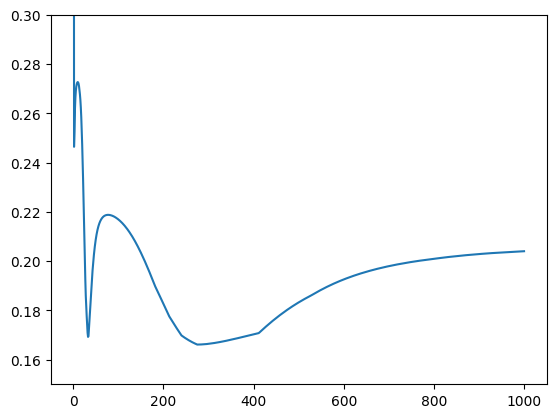

In [21]:
d0_values = np.linspace(0.0000001, 1000, 1000)
print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mae = mean_absolute_error(Y_val, Y_pred)
    results[d0_values[i]] = mae

plt.ylim(0.15, 0.3)
plt.plot(results.keys(), results.values())

In [22]:
RBF_model = RBF(d0=min(results, key=results.get))
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0000699
      Initializing linear solver - done. Time (sec):  0.0000803
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0000131
      Solving linear system (col. 0) - done. Time (sec):  0.0000210
   Training - done. Time (sec):  0.0003371


In [23]:
predicted_values_RBF = RBF_model.predict_values(generating_array_scaled)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0004079
   
   Prediction time/pt. (sec) :  0.0000041
   


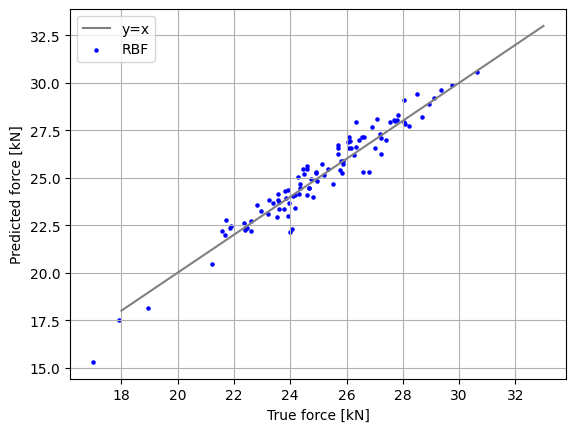

In [24]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,predicted_values_RBF , s=5, label='RBF', color='blue')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [25]:
gamma_values = np.logspace(-4, 2, num=50)
C_values = np.logspace(-1, 4, num=50)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

In [26]:
SVR_model = SVR(kernel='rbf', C=100, gamma= 0.1)
#SVR_model = SVR(kernel='rbf', epsilon=0.001, C=5.21)
SVR_model.fit(X_train,Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

In [27]:
Y_predicted_SVR = SVR_model.predict(generating_array_scaled)

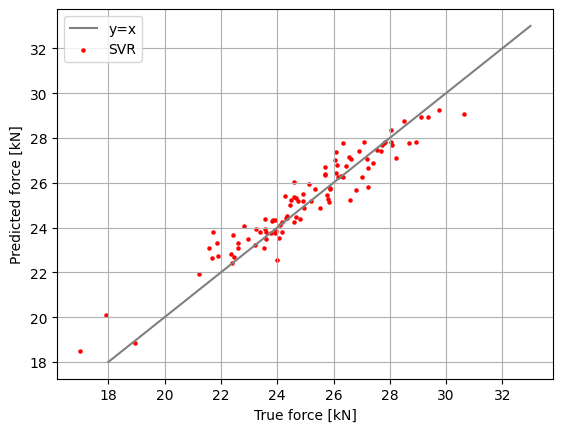

In [28]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [29]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.0164390


In [30]:
Y_predicted_KRG = KRG_model.predict_values(generating_array_scaled)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0103288
   
   Prediction time/pt. (sec) :  0.0001033
   


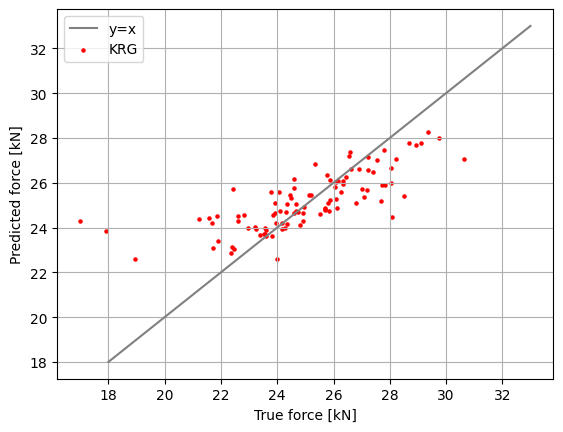

In [31]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,Y_predicted_KRG, s=5, label= 'KRG', color='red')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [32]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(optimizer='adam', loss='mse')

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
3/3 [==============================] - 0s 40ms/step - loss: 629.1168 - val_loss: 617.5646
Epoch 2/1000
3/3 [==============================] - 0s 7ms/step - loss: 621.0163 - val_loss: 609.7477
Epoch 3/1000
3/3 [==============================] - 0s 7ms/step - loss: 612.7601 - val_loss: 601.5172
Epoch 4/1000
3/3 [==============================] - 0s 10ms/step - loss: 603.9030 - val_loss: 592.1014
Epoch 5/1000
3/3 [==============================] - 0s 8ms/step - loss: 593.5628 - val_loss: 580.9756
Epoch 6/1000
3/3 [==============================] - 0s 7ms/step - loss: 581.2310 - val_loss: 567.9327
Epoch 7/1000
3/3 [==============================] - 0s 7ms/step - loss: 567.1161 - val_loss: 552.6005
Epoch 8/1000
3/3 [==============================] - 0s 7ms/step - loss: 550.5086 - val_loss: 534.7991
Epoch 9/1000
3/3 [==============================] - 0s 6ms/step - loss: 531.0513 - val_loss: 514.2502
Epoch 10/1000
3/3 [==============================] - 0s 7ms/step - loss: 508.838

In [33]:
Y_predicted_ANN = model.predict(generating_array_scaled)

4/4 [==============================] - 0s 571us/step


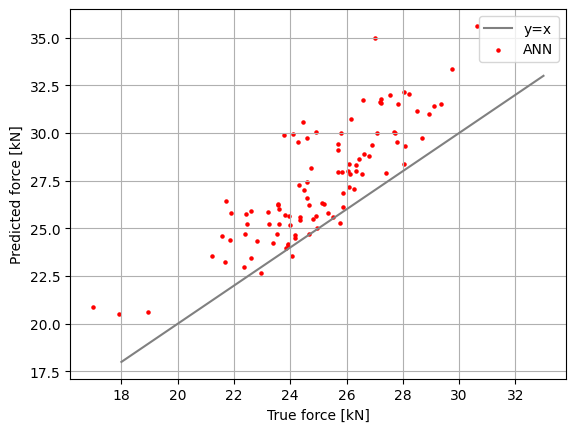

In [34]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')
plt.scatter(Y_EXT,Y_predicted_ANN, s=5, label= 'ANN', color='red')
plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

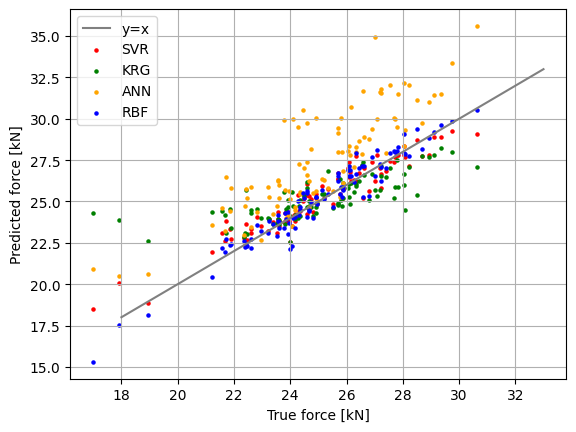

In [35]:
plt.plot([18,33], [18, 33], label='y=x', color='gray')

plt.scatter(Y_EXT,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.scatter(Y_EXT, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_EXT, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_EXT, predicted_values_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.grid()
plt.legend()

In [36]:
mape_KRG = mean_absolute_percentage_error(Y_EXT, Y_predicted_KRG)
mape_RBF = mean_absolute_percentage_error(Y_EXT, predicted_values_RBF)
mape_SVR = mean_absolute_percentage_error(Y_EXT, Y_predicted_SVR)
mape_ANN = mean_absolute_percentage_error(Y_EXT, Y_predicted_ANN)
print("MAPE, for KRG:", round(mape_KRG, 4)*100, "%")
print("MAPE, for RBF:", round(mape_RBF, 4)*100, "%")
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")
print("MAPE, for ANN:", round(mape_ANN, 4)*100, "%")

MAPE, for KRG: 4.79 %
MAPE, for RBF: 2.09 %
MAPE, for SVR: 2.40 %
MAPE, for ANN: 9.48 %
